# EECS 598 - Deep Learning in Computer Vision Project

## Image Classification

##### By,
##### Aman Kushwaha (UMID: 31158876), 
##### Deepthi Antony (UMID: 06685044),
##### Neha Kumar (UMID: 57554297),
##### Saurabh Budholiya (UMID: 56350227)

In this project, we build an image classification system. We collected our own image classification dataset, and trained classification models by transfer learning from networks pretrained on ImageNet. As well as, we implemented out version of ResNet__ from scratch. We explored several options and hyperparameters, and analyzed the performance of the trained networks.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab.


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import sys

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Project'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['downloads', 'test_data', 'Neha_Image_classification.ipynb', 'Deepthi_Image_classification.ipynb', 'Hyperparameters tested.gsheet', '__pycache__', 'Aman_Image_classification.ipynb', 'Trained_model', 'Saurabh_Image_classification.ipynb', 'image_classification.py', 'Copy of Image_classification.ipynb', 'Image_classification.ipynb', 'Copy of Final_Submission.ipynb', 'Accuracy.gsheet', 'Final_Submission.ipynb']


In [4]:
import os
import time

os.environ["TZ"] = "US/Eastern"
time.tzset()

from image_classification import hello_img


hello_img()

Hello from image_classification.py!


# **Getting Images for the Dataset**

We used the [Google Image Download](https://google-images-download.readthedocs.io/en/latest/index.html) Command Line program which web scrapes through Google Images and retrives the first N number of images, given a query.


We are primarily focused on image dataset for animals. So, our final labels in our dataset consisted of 6 categories:-

**Cat, Dog, Giraffe, Lion, Elephant, Crocodile**


In [5]:
!pip install google_images_download

# We run the following line to save each of these queries into it's appropriate folders
# -k is used to define the keyword/query and -l is used to define the limit of images to be downloaded
# Commenting the line as it takes a while to download all images

# !googleimagesdownload -k "Elephants, Lions, Giraffes, Crocodiles, Cats, Dogs" -l 200

     |████████████████████████████████| 968 kB 37.6 MB/s 
     |████████████████████████████████| 359 kB 75.8 MB/s 
     |████████████████████████████████| 138 kB 90.7 MB/s 
     |████████████████████████████████| 3.6 MB 50.7 MB/s 
     |████████████████████████████████| 55 kB 4.8 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=cb7b70ce17194c3cf1c074d0938230db6babaf893ff5661f5aa0bce52a704b4f
  Stored in directory: /root/.cache/pip/wheels/e3/98/42/0d3a76d46cd5a6659afb2f5612d4908ca42d34060973d46727
Successfully built google-images-download
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

# **Labelling Data**

We label the data by taking advantage of the segregation of the images into folders. We use the folder name as the label for every image in it.

Furthermore, since Google Images contain the most popular or relevant image to the search query, we cannot always find exactly what we need. Thus, we manually went through each image to remove the one's which would be a bad fit for the dataset. For example, cartoon images of elephants or images that contain huge texts in it. 

Lastly, we needed to resize our image as scraping images from the internet have varying resolutions, also when we are training neural network models, we don't want our inputs to be of varying sizes and want to remain consistent. We do this while loading the data.

# **Loading Training Data**

As mentioned above, we save the labels and resize the data while loading it in our "images" tensor.

We load the data as follows

In [10]:
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

data_path = '/content/drive/MyDrive/Project/downloads'
categories = ['cat', 'crocodile', 'dog', 'elephant', 'giraffe', 'lion']
label = {'cat': 0,'crocodile': 1, 'dog': 2, 'elephant': 3,'giraffe': 4, 'lion': 5 }

image_data = []
image_label = []

for category in categories:
  print("Loading ", category,"images")
  path = os.path.join(data_path, category)
  for img in os.listdir(path):
    image_arr = cv2.imread(os.path.join(path, img))  #One image of dim (W, H, 3)

    #Resizing
    new_image = cv2.resize(image_arr, (224,224))   #taking image size to be (224,224,3)

    image_data.append(new_image)
    image_label.append(label[category])
    
  
images = np.array(image_data)
labels = np.array(image_label)

print("Training images shape: " ,images.shape)      #Images are in numpy array
print("Training Labels shape: ",labels.shape)      #Labels are in numpy array

Loading  cat images
Loading  crocodile images
Loading  dog images
Loading  elephant images
Loading  giraffe images
Loading  lion images
Training images shape:  (934, 224, 224, 3)
Training Labels shape:  (934,)


# **Loading Test Data**

The test data is not downloaded from google images. As we wanted our models to be robust on different data sources

We used this website for test data source - https://unsplash.com/. For testing purpose, we downloaded images manually checking various alignment of images to ensure that the model is robust to rotation and translation. We kept 15 images per category for testing

In [11]:
#Test Data

data_path = '/content/drive/MyDrive/Project/test_data'
categories = ['cat', 'crocodile', 'dog', 'elephant', 'giraffe', 'lion']
label = {'cat': 0,'crocodile': 1, 'dog': 2, 'elephant': 3,'giraffe': 4, 'lion': 5 }

test_data = []
test_label = []

for category in categories:
  print(category)
  path = os.path.join(data_path, category)
  for img in os.listdir(path):
    test_image_arr = cv2.imread(os.path.join(path, img))  #One image of dim (W, H, 3)

    #Resizing
    new_test_image = cv2.resize(test_image_arr, (224,224))   #taking image size to be (224,224,3)
    
    test_data.append(new_test_image)
    test_label.append(label[category])
    
  
test_images = np.array(test_data)
test_labels = np.array(test_label)

print("Test images shape: " ,test_images.shape)      #Images are in numpy array
print("Test Labels shape: ",test_labels.shape)

cat
crocodile
dog
elephant
giraffe
lion
Test images shape:  (90, 224, 224, 3)
Test Labels shape:  (90,)


We will use GPUs to accelerate our computation in this notebook.

In [12]:
import torch

#Converting the images into tensor
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'


cuda GPU is available


Converting our images into tensors for further computations

In [13]:
images = torch.tensor(images, device = DEVICE)
labels = torch.tensor(labels, device = DEVICE)
test_images = torch.tensor(test_images, device = DEVICE)
test_labels = torch.tensor(test_labels, device = DEVICE)

# Visualizing our Images

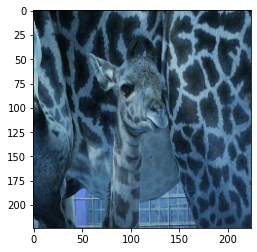

In [14]:
from image_classification import image_display

#This displays the given image
image_display(images[600])

Classes for above Images: 0 	 1 	 2 		 3 		 4 		 5


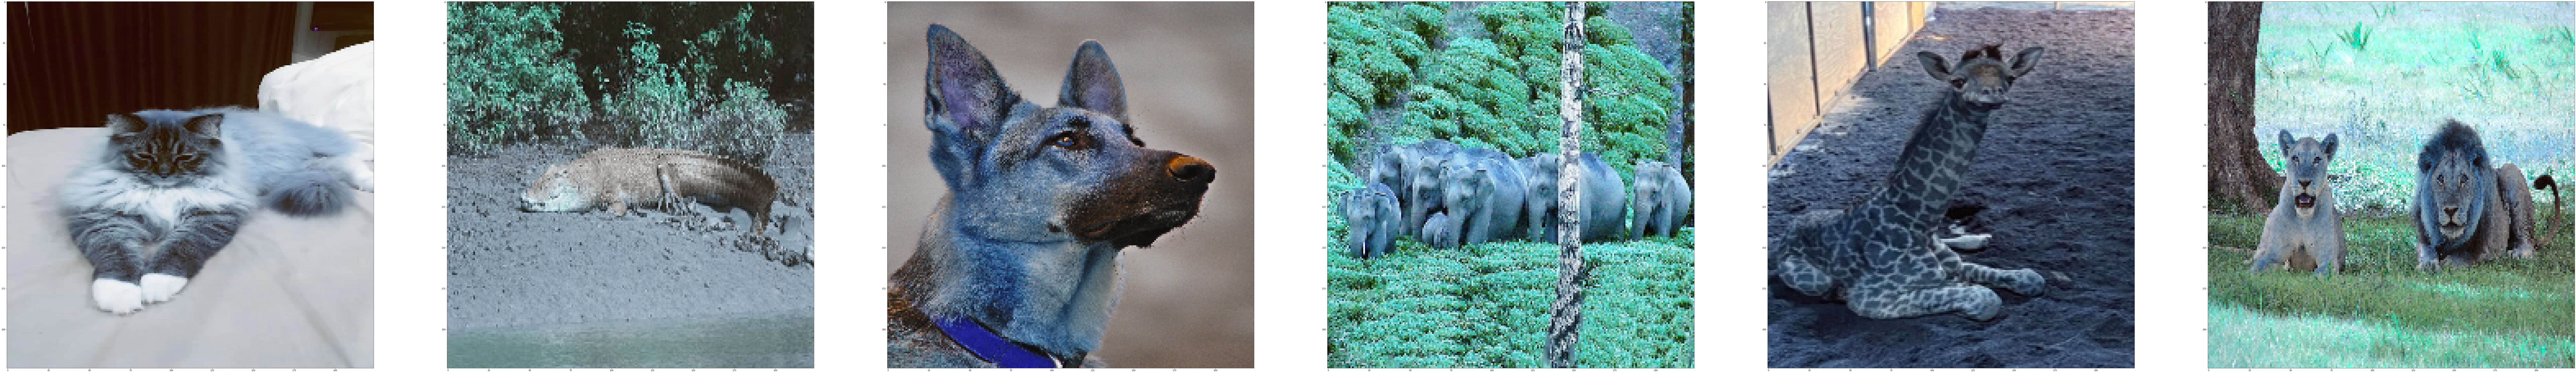

In [15]:
from image_classification import sample_image_disp

#Visualizing classes of our images
sample_image_disp(images, labels)

### Updating our image dimensions which will be accepted by the the model

In [16]:

images = images.permute(0,3,1,2)
images = images.float()

test_images = test_images.permute(0,3,1,2)
test_images = test_images.float()

# **Downloading pre-trained models from PyTorch**
The selection of pretrained models was based on various factors, some simple models with fewer layers and some deep models. The models which we used are as follows:-

1) ResNet18 <br>
2) ResNet50 <br>
3) GoogleNet <br>
4) VGG <br>
5) AlexNet <br>

We also fine tune these models. Fine-tuning is a way of applying or utilizing transfer learning. Specifically, fine-tuning is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task.

Further more, we have downloaded untrained ResNet Model and trained it using our data as well as we have implemented ResNet18 from scratch to show the comparsions

In [17]:
import seaborn as sns

# Fine Tuning on Different Pretrained Models/Architectures


## Fine tuning ResNet18

In [14]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_rn18_p = models.resnet18(pretrained = True)    #Downloading Pretrained resnet18 model from pytorch

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
from image_classification import fine_tuning

num_features = model_rn18_p.fc.in_features    #512
model_rn18_p.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_rn18_p.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn18_p.parameters(), lr=0.001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained ResNet18 Model (Performing fine tuning on our dataset)


Epoch  0  Loss is:  1.9642579555511475
Epoch  10  Loss is:  0.3217479884624481
Epoch  20  Loss is:  0.14824727177619934
Epoch  30  Loss is:  0.14315734803676605
Epoch  40  Loss is:  0.30632466077804565
Epoch  50  Loss is:  0.16923905909061432
Epoch  60  Loss is:  0.026060953736305237
Epoch  70  Loss is:  0.07345230132341385
Epoch  80  Loss is:  0.01058173831552267
Epoch  90  Loss is:  0.004630077630281448
Epoch  100  Loss is:  0.008101120591163635
Epoch  110  Loss is:  0.0024408167228102684
Epoch  120  Loss is:  0.003156316466629505
Epoch  130  Loss is:  0.014871232211589813
Epoch  140  Loss is:  0.005250300280749798
Epoch  150  Loss is:  0.0030757258646190166
Epoch  160  Loss is:  0.00887161586433649
Epoch  170  Loss is:  0.001275897491723299
Epoch  180  Loss is:  0.0027964774053543806
Epoch  190  Loss is:  0.004669723100960255


<function matplotlib.pyplot.show>

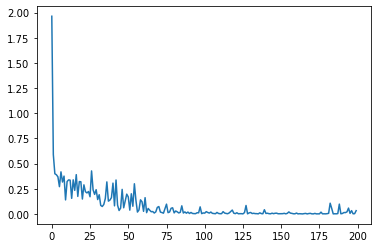

In [16]:
from image_classification import run_model

loss_graph_rn18_p = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_rn18_p, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_rn18_p.append(loss.cpu().item())

plt.plot(loss_graph_rn18_p)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on ResNet18

In [19]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_rn18_p = images[random_no]
y_batch_rn18_p = labels[random_no]
y_pred_rn18_p = model_rn18_p(x_batch_rn18_p)

y_pred_rn18_p = torch.argmax(y_pred_rn18_p, axis = 1)

train_acc_rn18_p = ((torch.sum(y_pred_rn18_p == y_batch_rn18_p))/(batch_size))*100
print("Training accuracy: ", train_acc_rn18_p.item())

Training accuracy:  100.0


In [20]:
from image_classification import calculate_accuracy

y_pred_rn18_p_ = model_rn18_p(test_images)
y_pred_rn18_p = torch.argmax(y_pred_rn18_p_, axis=1)
accuracy_rn18_p = calculate_accuracy(test_images, y_pred_rn18_p_, test_labels, test_images.shape[0])

print("The accuracy of test data on ResNet18 is: ", accuracy_rn18_p.item())

The accuracy of test data on ResNet18 is:  91.11111450195312


### Confusion Matrix - ResNet18 Pretrained

In [18]:
from image_classification import confusion_matrix_display

Confusion Matrix for ResNet18 Model


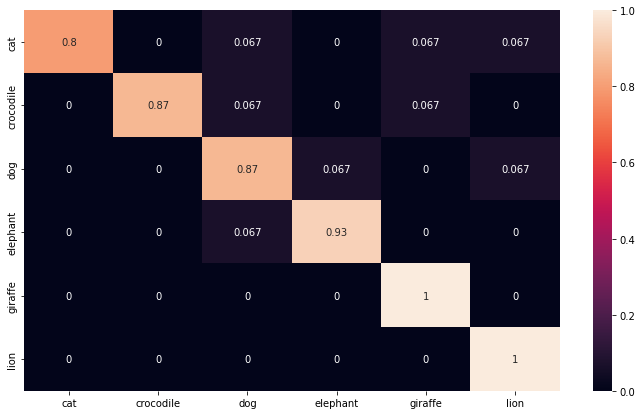

In [22]:
cf_rn18_p = confusion_matrix_display(y_pred_rn18_p, test_labels)

print("Confusion Matrix for ResNet18 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_rn18_p, annot=True)

In [19]:
from image_classification import saliency_maps

### Qualitative Examples and Saliency Map - ResNet18 Pretrained

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

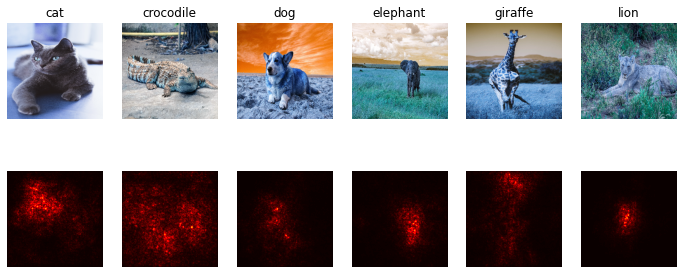

In [24]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_rn18_p[temp_img], model_rn18_p)



## Fine tuning ResNet50

In [25]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_rn50 = models.resnet50(pretrained = True)    

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [26]:
from image_classification import fine_tuning

import time
import copy

num_features = model_rn50.fc.in_features    #512
model_rn50.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_rn50.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn50.parameters(), lr=0.001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained ResNet50 Model (Performing fine tuning on our dataset)

Epoch  0  Loss is:  1.839975357055664
Epoch  10  Loss is:  0.23745311796665192
Epoch  20  Loss is:  0.32373738288879395
Epoch  30  Loss is:  0.3019123673439026
Epoch  40  Loss is:  0.3054659068584442
Epoch  50  Loss is:  0.26919716596603394
Epoch  60  Loss is:  0.10315735638141632
Epoch  70  Loss is:  0.22718234360218048
Epoch  80  Loss is:  0.1821303814649582
Epoch  90  Loss is:  0.16048957407474518
Epoch  100  Loss is:  0.18400031328201294
Epoch  110  Loss is:  0.10994206368923187
Epoch  120  Loss is:  0.06975682824850082
Epoch  130  Loss is:  0.044987548142671585
Epoch  140  Loss is:  0.10617227107286453
Epoch  150  Loss is:  0.013731149025261402
Epoch  160  Loss is:  0.15461578965187073
Epoch  170  Loss is:  0.07357589900493622
Epoch  180  Loss is:  0.008225950412452221
Epoch  190  Loss is:  0.03319708630442619


<function matplotlib.pyplot.show>

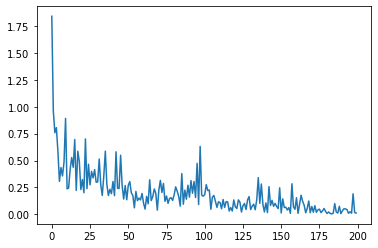

In [27]:
from image_classification import run_model

loss_graph_rn50 = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_rn50, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_rn50.append(loss.cpu().item())

plt.plot(loss_graph_rn50)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on ResNet50

In [28]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_rn50 = images[random_no]
y_batch_rn50 = labels[random_no]
y_pred_rn50 = model_rn50(x_batch_rn50)

y_pred_rn50 = torch.argmax(y_pred_rn50, axis = 1)

train_acc_rn50 = ((torch.sum(y_pred_rn50 == y_batch_rn50))/(batch_size))*100
print("Training accuracy: ", train_acc_rn50.item())

Training accuracy:  tensor(96., device='cuda:0')


In [29]:
from image_classification import calculate_accuracy

y_pred_rn50_ = model_rn50(test_images)
y_pred_rn50 = torch.argmax(y_pred_rn50_, axis=1)
accuracy_rn50 = calculate_accuracy(test_images, y_pred_rn50_, test_labels, test_images.shape[0])

print("The accuracy of test data on ResNet50 is: ", accuracy_rn50.item())

The accuracy of test data on ResNet50 is:  88.8888931274414


### Confusion Matrix - ResNet50

Confusion Matrix for ResNet50 Model


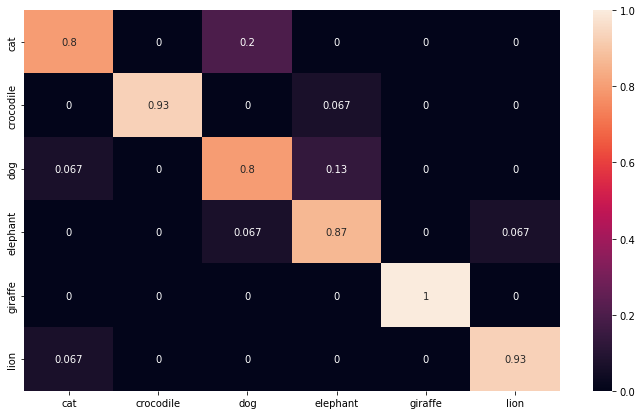

In [30]:
cf_rn50 = confusion_matrix_display(y_pred_rn50, test_labels)

print("Confusion Matrix for ResNet50 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_rn50, annot=True)

### Qualitative Examples and Saliency Map - ResNet50

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

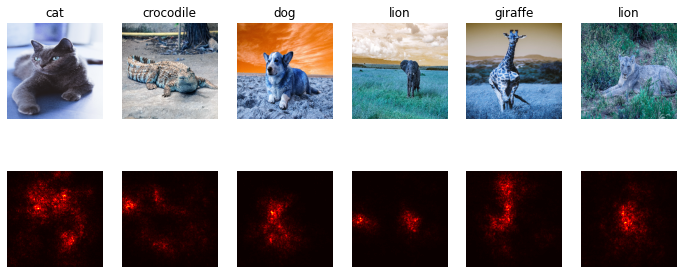

In [31]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_rn50[temp_img], model_rn50)



## Fine tuning Googlenet

In [14]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_gn = models.googlenet(pretrained = True)   

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [15]:
from image_classification import fine_tuning

import time
import copy

num_features = model_gn.fc.in_features    #512
model_gn.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_gn.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gn.parameters(), lr=0.0001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained Googlenet Model (Performing fine tuning on our dataset)

Epoch  0  Loss is:  1.8739904165267944
Epoch  10  Loss is:  1.1188673973083496
Epoch  20  Loss is:  0.6650721430778503
Epoch  30  Loss is:  0.4051763415336609
Epoch  40  Loss is:  0.21045340597629547
Epoch  50  Loss is:  0.15157769620418549
Epoch  60  Loss is:  0.0710306465625763
Epoch  70  Loss is:  0.08483174443244934
Epoch  80  Loss is:  0.04578952491283417
Epoch  90  Loss is:  0.04923822730779648
Epoch  100  Loss is:  0.03370840474963188
Epoch  110  Loss is:  0.03036365658044815
Epoch  120  Loss is:  0.023454902693629265
Epoch  130  Loss is:  0.01752777397632599
Epoch  140  Loss is:  0.017724834382534027
Epoch  150  Loss is:  0.015029159374535084
Epoch  160  Loss is:  0.010141291655600071
Epoch  170  Loss is:  0.010163264349102974
Epoch  180  Loss is:  0.02543751150369644
Epoch  190  Loss is:  0.01487580593675375


<function matplotlib.pyplot.show>

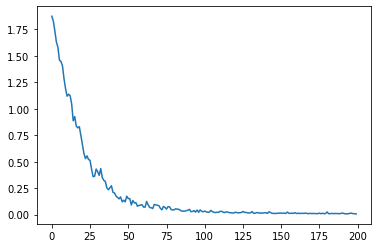

In [16]:
from image_classification import run_model

loss_graph_gn = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_gn, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_gn.append(loss.cpu().item())

plt.plot(loss_graph_gn)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on GoogleNet

In [20]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_gn = images[random_no]
y_batch_gn = labels[random_no]
y_pred_gn = model_gn(x_batch_gn)

y_pred_gn = torch.argmax(y_pred_gn, axis = 1)

train_acc_gn = ((torch.sum(y_pred_gn == y_batch_gn))/(batch_size))*100
print("Training accuracy: ", train_acc_gn.item())

Training accuracy:  100.0


In [21]:
from image_classification import calculate_accuracy

y_pred_gn_ = model_gn(test_images)
y_pred_gn = torch.argmax(y_pred_gn_, axis=1)

accuracy_gn = calculate_accuracy(test_images, y_pred_gn_, test_labels, test_images.shape[0])

print("The accuracy of test data on GoogleNet is: ", accuracy_gn.item())

The accuracy of test data on GoogleNet is:  100.0


### Confusion Matrix - GoogleNet

In [22]:
from image_classification import confusion_matrix_display, saliency_maps
import seaborn as sns

Confusion Matrix for GoogleNet Model


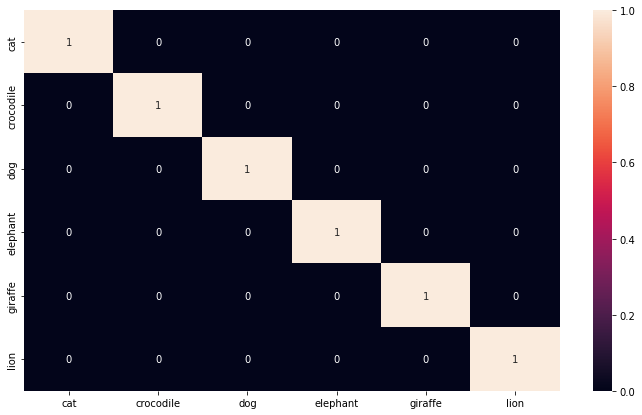

In [23]:
cf_gn = confusion_matrix_display(y_pred_gn, test_labels)

print("Confusion Matrix for GoogleNet Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_gn, annot=True)

### Qualitative Examples and Saliency Map - GoogleNet

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

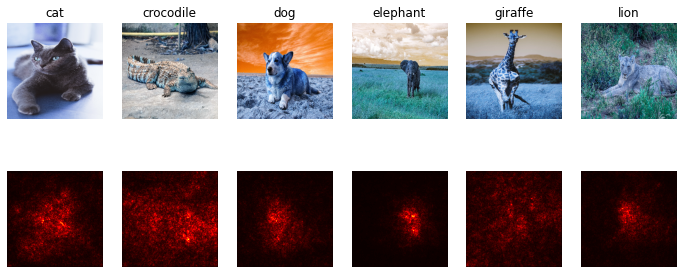

In [24]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_gn[temp_img], model_gn)

## Fine tuning VGG19

In [20]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_vgg = models.vgg19(pretrained=True)    

In [21]:
from image_classification import fine_tuning

import time
import copy

num_features = model_vgg.classifier[6].in_features    #512
model_vgg.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_vgg.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=0.0001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the pretrained VGG19 Model (Performing fine tuning on our dataset)

Epoch  0  Loss is:  139.41600036621094
Epoch  10  Loss is:  2.585085868835449
Epoch  20  Loss is:  1.9612627029418945
Epoch  30  Loss is:  1.6348799467086792
Epoch  40  Loss is:  1.321963906288147
Epoch  50  Loss is:  1.0796127319335938
Epoch  60  Loss is:  1.1636981964111328
Epoch  70  Loss is:  0.7674794793128967
Epoch  80  Loss is:  0.7835309505462646
Epoch  90  Loss is:  0.6072983741760254
Epoch  100  Loss is:  0.5807814002037048
Epoch  110  Loss is:  0.48913198709487915
Epoch  120  Loss is:  0.615126371383667
Epoch  130  Loss is:  0.45261746644973755
Epoch  140  Loss is:  0.2152749001979828
Epoch  150  Loss is:  0.25726550817489624
Epoch  160  Loss is:  0.29754820466041565
Epoch  170  Loss is:  0.28253835439682007
Epoch  180  Loss is:  0.027687739580869675
Epoch  190  Loss is:  0.18895605206489563


<function matplotlib.pyplot.show>

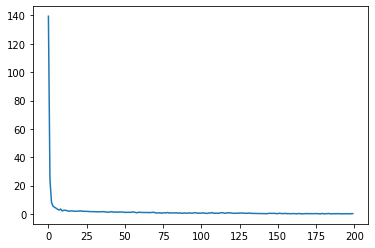

In [22]:
from image_classification import run_model

loss_graph_vgg = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_vgg, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_vgg.append(loss.cpu().item())

plt.plot(loss_graph_vgg)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on VGG

In [23]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_vgg = images[random_no]
y_batch_vgg = labels[random_no]
y_pred_vgg = model_vgg(x_batch_vgg)

y_pred_vgg = torch.argmax(y_pred_vgg, axis = 1)

train_acc_vgg = ((torch.sum(y_pred_vgg == y_batch_vgg))/(batch_size))*100
print("Training accuracy: ", train_acc_vgg)

Training accuracy:  tensor(97., device='cuda:0')


In [24]:
from image_classification import calculate_accuracy

y_pred_vgg_ = model_vgg(test_images)
y_pred_vgg = torch.argmax(y_pred_vgg_, axis=1)

accuracy_vgg = calculate_accuracy(test_images, y_pred_vgg_, test_labels, test_images.shape[0])

print("The accuracy of test data on VGG is: ", accuracy_vgg.item())

The accuracy of test data on VGG is:  68.8888931274414


### Confusion Matrix - VGG19

Confusion Matrix for VGG Model


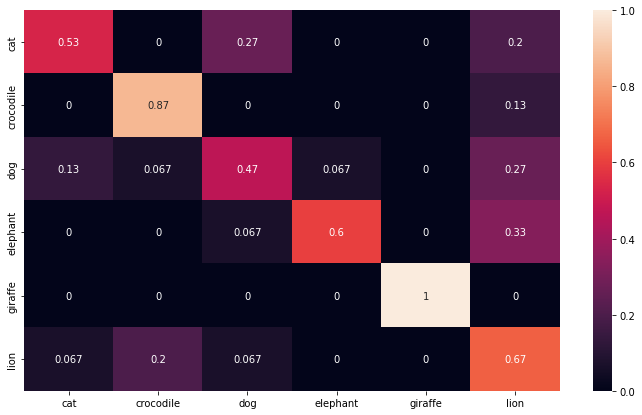

In [25]:
cf_vgg = confusion_matrix_display(y_pred_vgg, test_labels)

print("Confusion Matrix for VGG Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_vgg, annot=True)

### Qualitative Examples and Saliency Map - VGG19

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

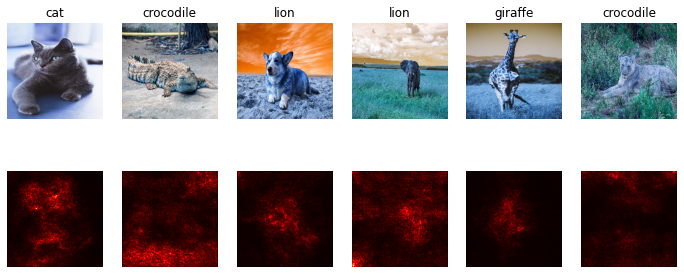

In [26]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_vgg[temp_img], model_vgg)

## Training the pretrained Alexnet Model (Performing fine tuning on our dataset)

In [25]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_an = models.alexnet(pretrained=True)    

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [26]:
from image_classification import fine_tuning

import time
import copy

num_features = model_an.classifier[6].in_features    #512
model_an.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_an.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_an.parameters(), lr=0.0001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training on the AlexNet Model

Epoch  0  Loss is:  225.27743530273438
Epoch  10  Loss is:  7.897021770477295
Epoch  20  Loss is:  3.648725986480713
Epoch  30  Loss is:  2.305546760559082
Epoch  40  Loss is:  2.306107997894287
Epoch  50  Loss is:  2.0710954666137695
Epoch  60  Loss is:  1.6371630430221558
Epoch  70  Loss is:  1.5847890377044678
Epoch  80  Loss is:  1.4736270904541016
Epoch  90  Loss is:  1.4599746465682983
Epoch  100  Loss is:  1.5195088386535645
Epoch  110  Loss is:  1.2499784231185913
Epoch  120  Loss is:  1.193458080291748
Epoch  130  Loss is:  1.1470692157745361
Epoch  140  Loss is:  1.0444592237472534
Epoch  150  Loss is:  1.0684806108474731
Epoch  160  Loss is:  0.8370802998542786
Epoch  170  Loss is:  0.7484394907951355
Epoch  180  Loss is:  0.9801949858665466
Epoch  190  Loss is:  1.1454793214797974


<function matplotlib.pyplot.show>

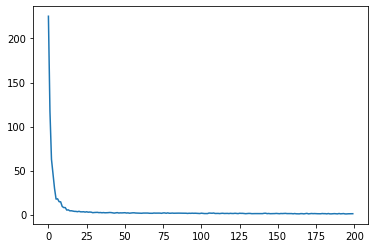

In [27]:
from image_classification import run_model

loss_graph_an = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_an, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_an.append(loss.cpu().item())

plt.plot(loss_graph_an)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on AlexNet

In [28]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_an = images[random_no]
y_batch_an = labels[random_no]
y_pred_an = model_an(x_batch_an)

y_pred_an = torch.argmax(y_pred_an, axis = 1)

train_acc_an = ((torch.sum(y_pred_an == y_batch_an))/(batch_size))*100
print("Training accuracy: ", train_acc_an.item())

Training accuracy:  tensor(63., device='cuda:0')


In [29]:
from image_classification import calculate_accuracy

y_pred_an_ = model_an(test_images)
y_pred_an = torch.argmax(y_pred_an_, axis=1)

accuracy_an = calculate_accuracy(test_images, y_pred_an_, test_labels, test_images.shape[0])

print("The accuracy of test data on AlexNet is: ", accuracy_an.item())

The accuracy of test data on AlexNet is:  46.66666793823242


### Confusion Matrix - AlexNet

Confusion Matrix for AlexNet Model


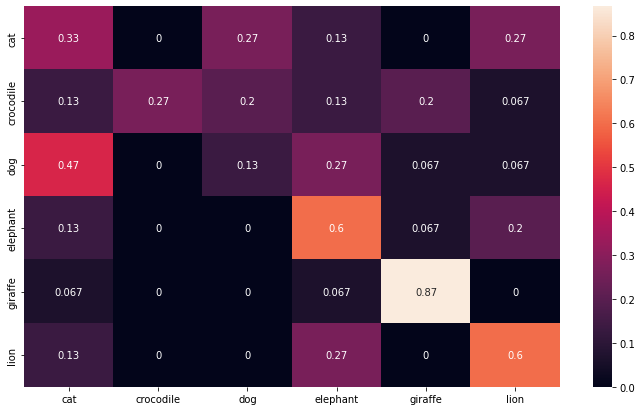

In [30]:
cf_an = confusion_matrix_display(y_pred_an, test_labels)

print("Confusion Matrix for AlexNet Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_an, annot=True)

### Qualitative Examples and Saliency Map - AlexNet

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

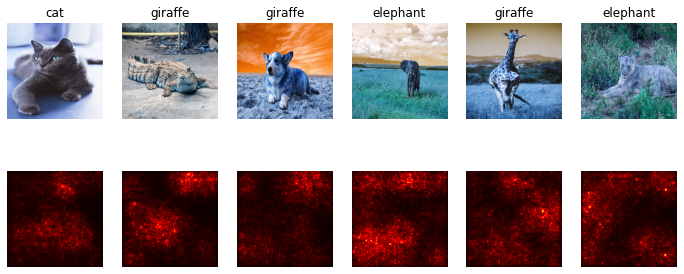

In [31]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_an[temp_img], model_an)

# **Downloading Un-trained ResNet18 Model from PyTorch**

In [32]:
import torchvision.models as models
from torch.optim import lr_scheduler
model_rn18_u = models.resnet18()    #Downloading the untrained resnet18 model


## Fine Tuning the Untrained Resnet18 model


In [33]:
from image_classification import fine_tuning

import time
import copy

num_features = model_rn18_u.fc.in_features    #512
model_rn18_u.fc = torch.nn.Linear(num_features,6)    #Total 6 class
model_rn18_u.to(device= DEVICE);

loss_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn18_u.parameters(), lr=0.001)     #Adjust Learning rate from here
step_lr = lr_scheduler.StepLR(optimizer, step_size= 10, gamma = 0.5)   #Every 10 epochs our learning rate will be multiplied by gamma


## Training the Untrained Resnet18 Model (Performing fine tuning on our dataset)




Epoch  0  Loss is:  1.7417120933532715
Epoch  10  Loss is:  1.6960537433624268
Epoch  20  Loss is:  1.5704007148742676
Epoch  30  Loss is:  1.2723791599273682
Epoch  40  Loss is:  1.2156745195388794
Epoch  50  Loss is:  1.1696209907531738
Epoch  60  Loss is:  0.9326914548873901
Epoch  70  Loss is:  1.0292068719863892
Epoch  80  Loss is:  0.915958046913147
Epoch  90  Loss is:  0.903510332107544
Epoch  100  Loss is:  1.1154141426086426
Epoch  110  Loss is:  1.047342300415039
Epoch  120  Loss is:  0.8392459750175476
Epoch  130  Loss is:  1.0100336074829102
Epoch  140  Loss is:  0.5885215401649475
Epoch  150  Loss is:  0.7281281352043152
Epoch  160  Loss is:  1.1008875370025635
Epoch  170  Loss is:  0.6556122303009033
Epoch  180  Loss is:  0.7743273973464966
Epoch  190  Loss is:  0.4603959918022156


<function matplotlib.pyplot.show>

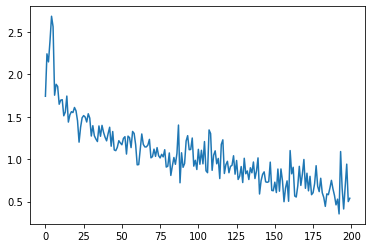

In [34]:
from image_classification import run_model

loss_graph_rn18_u = []

num_epochs = 200
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  loss = run_model(model_rn18_u, x_batch, y_batch, loss_type, optimizer)     #C,H,W
  if i%10 == 0:
    print("Epoch ", i, " Loss is: ", loss.item())
  loss_graph_rn18_u.append(loss.cpu().item())

plt.plot(loss_graph_rn18_u)
plt.show

#Loss curve

### Running model on test images and calculating accuracy on our ResNet18 Model

In [35]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch_rn18_u = images[random_no]
y_batch_rn18_u = labels[random_no]
y_pred_rn18_u = model_rn18_u(x_batch_rn18_u)

y_pred_rn18_u = torch.argmax(y_pred_rn18_u, axis = 1)

train_acc_rn18_u = ((torch.sum(y_pred_rn18_u == y_batch_rn18_u))/(batch_size))*100
print("Training accuracy: ", train_acc_rn18_u.item())

Training accuracy:  tensor(76., device='cuda:0')


In [36]:
from image_classification import calculate_accuracy

y_pred_rn18_u_ = model_rn18_u(test_images)
y_pred_rn18_u = torch.argmax(y_pred_rn18_u_, axis=1)

accuracy_rn18_u = calculate_accuracy(test_images, y_pred_rn18_u_, test_labels, test_images.shape[0])

print("The accuracy of test data on our ResNet18 model is: ", accuracy_rn18_u.item())

The accuracy of test data on our ResNet18 model is:  67.77777862548828


### Confusion Matrix - Untrained ResNet18 Model

Confusion Matrix for ResNet18 Model


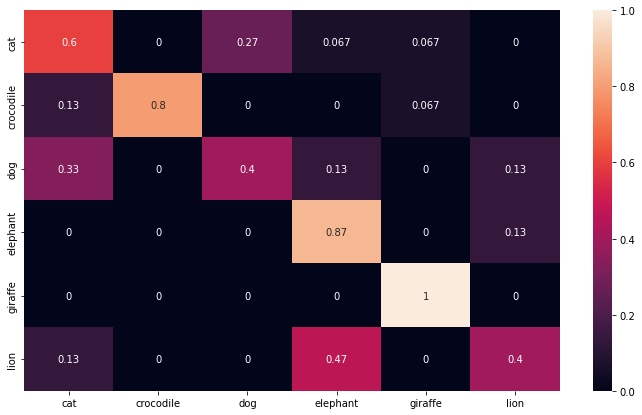

In [37]:
cf_rn18_u = confusion_matrix_display(y_pred_rn18_u, test_labels)

print("Confusion Matrix for ResNet18 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_rn18_u, annot=True)

### Qualitative Examples and Saliency Map -  Untrained ResNet18 Model

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

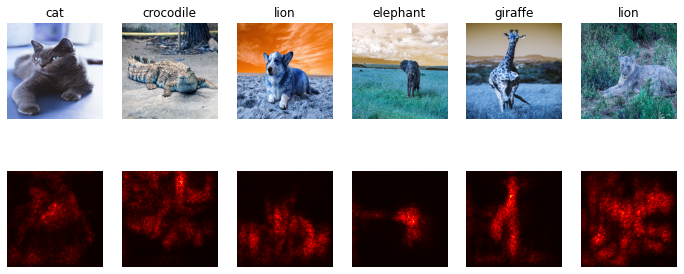

In [38]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred_rn18_u[temp_img], model_rn18_u)

# Creating an Architecture from scratch and training on our dataset

### A ResNet-18 model is implemented from scratch for the image classification. The model is implemented in PyTorch using Convolution, Batch Normalization, Maxpool, and Dropout layers.

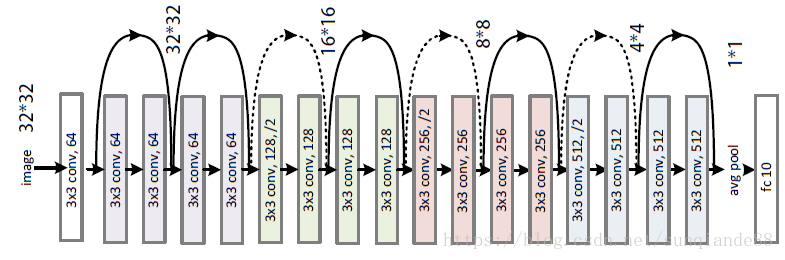
<br>
An input image of size (224 x 224) with 3 channels is passed through the first convolution layer. The number of filters used is 64 with kernel size (7 x 7) stride (2 x 2) and padding (3 x 3). This changes input image size from (224x224x3) to (112x112x64). The output of the first convolution layer is passed through a batch normalization layer and a maxpool layer from which we will get the output of the first block with size (56 x 56) and 64 channels. 


The output from Block-1 is passed through Block-2 where the image size is not changing. 
The first Convolution layer in Block -3 transforms the image to (28x28) image with 128 channels using a 3x3 kernel and 2x2 stride with 1x1 padding. The Batchnormaliztion and ReLU function is then applied on it. The second convolution layer takes this image as input and outputs the image with the same shape (28x28x128). 


The residual connection is applied by adding the output of Block-2, which is a (56x56x64) image, to the output of Block-3, which is a (28x28x128) image. The output of Block-2 is converted to (28x28x128) image by applying a convolution with (1 x1) filter and (2 x2) stride. The input channels will be 64 and the output channels will be 128. 


Whenever there is a need to adjust output to make it possible to apply a Residual connection a Convolution block is used, and whenever the input and output are the same Identity block is used.


Similarly, all the other blocks are created. 
After the Block-5, an average pooling operation is carried out where the image of size (7x7x512) is reduced to image of size (1x1x512) using a filter of size (7 x 7) and stride of 1. This image is flattened and passed to fully connected layers. The output from the last fully connected layer will be a vector of size equal to number of classes.


In [39]:
from image_classification import Cnn

model_own = Cnn(6).to(device = DEVICE)

optimizer = torch.optim.Adam(model_own.parameters(), lr=0.001)
loss_type = torch.nn.CrossEntropyLoss()


Epoch:  0 , loss is:  0.10269170999526978
Epoch:  10 , loss is:  0.05610114336013794
Epoch:  20 , loss is:  0.22004635632038116
Epoch:  30 , loss is:  0.07189343124628067
Epoch:  40 , loss is:  0.09028506278991699
Epoch:  50 , loss is:  0.10372674465179443
Epoch:  60 , loss is:  0.12884344160556793
Epoch:  70 , loss is:  0.05033043026924133
Epoch:  80 , loss is:  0.01612422987818718
Epoch:  90 , loss is:  0.03353045880794525
Epoch:  100 , loss is:  0.009246716275811195
Epoch:  110 , loss is:  0.15432550013065338
Epoch:  120 , loss is:  0.10541217029094696
Epoch:  130 , loss is:  0.0581333190202713
Epoch:  140 , loss is:  0.1493934988975525
Epoch:  150 , loss is:  0.012428202666342258
Epoch:  160 , loss is:  0.008126792497932911
Epoch:  170 , loss is:  0.008646946400403976
Epoch:  180 , loss is:  0.003506672102957964
Epoch:  190 , loss is:  0.0030128827784210443
Epoch:  200 , loss is:  0.0014305765507742763
Epoch:  210 , loss is:  0.06899352371692657
Epoch:  220 , loss is:  0.0830966979

<function matplotlib.pyplot.show>

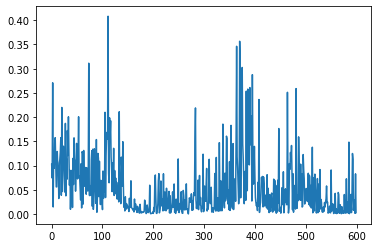

In [68]:
#Model Training
loss_graph = []
num_epochs = 600
num_train = images.shape[0]
batch_size = 64
for i in range(num_epochs):
  random_no = torch.randint(0, num_train, (batch_size,))
  x_batch = images[random_no]
  y_batch = labels[random_no]

  model_own.train()
  optimizer.zero_grad()
  y_pred = model_own(x_batch)
  loss = loss_type(y_pred, y_batch)
  loss.backward()
  optimizer.step()
  loss_graph.append(loss.cpu().item())
  if i%10==0:
    print("Epoch: ", i, ", loss is: ", loss.cpu().item())

plt.plot(loss_graph)
plt.show

# Calculating Accuracy of our model


In [69]:
#Calculationg training accuracy
batch_size = 100
random_no = torch.randint(0, num_train, (batch_size,))
x_batch = images[random_no]
y_batch = labels[random_no]
y_pred = model_own(x_batch)

y_pred = torch.argmax(y_pred, axis = 1)

train_acc = ((torch.sum(y_pred == y_batch))/(batch_size))*100
print("Training accuracy: ", train_acc.item())

Training accuracy:  97.99999237060547


In [70]:
from image_classification import calculate_accuracy

y_pred_ = model_own(test_images)
y_pred = torch.argmax(y_pred_, axis=1)

accuracy = calculate_accuracy(test_images, y_pred_, test_labels, test_images.shape[0])

print("The accuracy of test data on Our own Resnet18 Model is: ", accuracy.item())

The accuracy of test data on Our own Resnet18 Model is:  66.66667175292969


### Confusion Matrix on our ResNet18 Model implemented from scratch

Confusion Matrix for Our ResNet18 Model


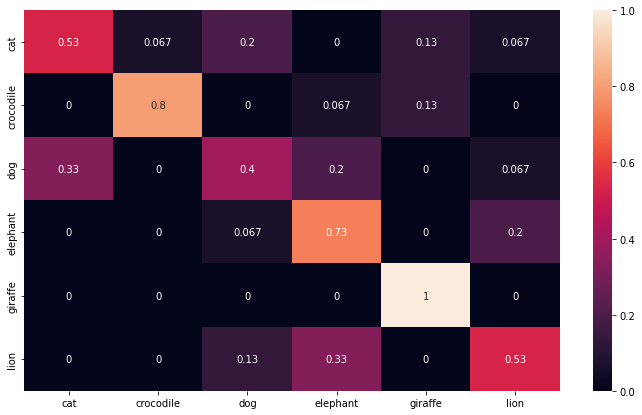

In [71]:
cf_model = confusion_matrix_display(y_pred, test_labels)

print("Confusion Matrix for Our ResNet18 Model")
plt.figure(figsize = (12,7))

sns.heatmap(cf_model, annot=True)


### Qualitative Examples and Saliency Maps on our ResNet18 Model implemented from scratch

We take images from each of the categories in the test data to assess the performance with qualitative examples. Through this, we can observe whether the predicted labels match the image. 

Moreover, we display the saliency maps as an attribution method to highlight the pixels which were relevant for image classification.

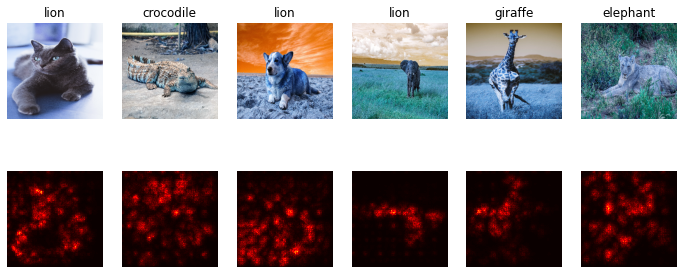

In [72]:
temp_img = [5, 18, 35, 59, 71, 88]

saliency = saliency_maps(test_images[temp_img], y_pred[temp_img], model_own)

# Results

# Observations for different Models:
1. **Resnet 18**: <br>
ResNet-18 is a convolutional neural network that is 18 layers deep. We trained 3 different types of ResNet18 models:
*   ***Pre-trained:*** Resnet18 is a simpler model which gave us moderately good results when compared to the other pre-trained models. When compared to other ResNet18 model implementations that we did, it definitely performed the best.
*   ***Untrained:*** The untrained model did not perform as well as the pre-trained model. The performance could have been improved with a larger training dataset.
* ***Implementing from Scratch:*** Our implementation of the ResNet18 Model following the architecture given in [this paper](https://arxiv.org/abs/1512.03385). It's performance was at par with that of the untrained ResNet18 model.

2. **ResNet50**: <br>
Since ResNet50 is a deeper model as compared to ResNet18, it look much longer to train this. Despite the depth of the model, it gave lesser accuracy than that of the pretrained ResNet18. This is because for deeper models, we need more training data and more number of epochs.

3. **GoogleNet**: <br>
GoogleNet performed best compared to all the models. It runs faster than other models. This higher computational efficiency is due to it's inception module in which a single layer contains multiple types of feature extractors.


4. **VGG**: <br>
The  main disadvantage of VGG lies in the fact that it took the most amount of time to train. Although the architecture is simple, the volume of the tensors after each layer are barely decreased, which leads to a higher execution time. Furthermore, accuracy of VGG is not as high as that of Residual Network models.

5. **AlexNet**: <br>
AlexNet is an inherently older architecture and performs badly among all the models that we trained on. The depth of this model is very less and hence it struggles to learn features from image sets. In order to get a higher accuracy, we would need to train it for longer.

# Best Models

The best two models were GoogleNet and ResNet18 (Pretrained). We have displayed the qualitative examples, confusion matrix and saliency maps (attribution methods) for each of the trianed models as they were trained. The performance of each of the model is summarized in the table below:
<br>
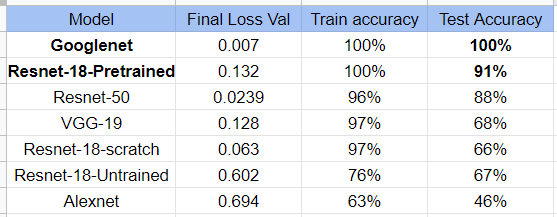
